<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/%5BTutorial%5D_Continual_Learning_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Gentle Introduction to Continual Learning in PyTorch

* Reference: https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb

We will start with learning over the standard MNIST benchmark, then we will move in the actual continual learning setting with the Permuted MNIST benchmark. Let's have some fun! :-)



**Requisites to run it locally, outside colab (not recommended)** <br>
* Python 3.x
* Jupyter
* PyTorch 0.4.0
* Numpy
* Matplotlib


In [1]:
! free -m
! df -h
! nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:          26124         728       22962           1        2433       25050
Swap:             0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   33G  115G  22% /
tmpfs            64M     0   64M   0% /dev
tmpfs            13G     0   13G   0% /sys/fs/cgroup
shm              13G     0   13G   0% /dev/shm
/dev/sda1       154G   34G  120G  22% /opt/bin
tmpfs            13G   32K   13G   1% /var/colab
tmpfs            13G     0   13G   0% /proc/acpi
tmpfs            13G     0   13G   0% /proc/scsi
tmpfs            13G     0   13G   0% /sys/firmware
Thu Jan 21 09:13:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id      

In [2]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:          26124         605       23091           1        2427       25168
Swap:             0           0           0


In [3]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   33G  115G  22% /
tmpfs            64M     0   64M   0% /dev
tmpfs            13G     0   13G   0% /sys/fs/cgroup
shm              13G     0   13G   0% /dev/shm
/dev/sda1       154G   34G  120G  22% /opt/bin
tmpfs            13G   28K   13G   1% /var/colab
tmpfs            13G     0   13G   0% /proc/acpi
tmpfs            13G     0   13G   0% /proc/scsi
tmpfs            13G     0   13G   0% /sys/firmware


In [4]:
! nvidia-smi

Thu Jan 21 09:13:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Questions to explore:**<br>
* How to connect your Google Drive with Google Colab?
* How to import a new notebook and save it to your GDrive?
* How to use files which contained in your GDrive?

## Installing PyTorch 0.4.0

In [5]:
import torch
torch.cuda.is_available()

True

이제는 Colab에서도 기본적으로 torch를 사용할 수 있다

alright!<br>
let us import a few libraries

In [7]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## MNIST: Digits recognition with PyTorch

* All right!, let's start it!
* Let's recognize the ten handwritten digits learning from 60,000, 28x28 grayscale images
* For simplicity let's import a loading script they have already developed inside the Continual AI Colab repository

In [8]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 137 (delta 7), reused 12 (delta 3), pack-reused 120
Receiving objects: 100% (137/137), 598.05 KiB | 852.00 KiB/s, done.
Resolving deltas: 100% (49/49), done.


In [9]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


In [10]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type", x_train.shape, x_train.dtype)
print("t_train dim and type", t_train.shape, t_train.dtype)
print("x_test dim and type", x_test.shape, x_test.dtype)
print("t_test dim and type", t_test.shape, t_test.dtype)

x_train dim and type (60000, 1, 28, 28) float32
t_train dim and type (60000,) uint8
x_test dim and type (10000, 1, 28, 28) float32
t_test dim and type (10000,) uint8


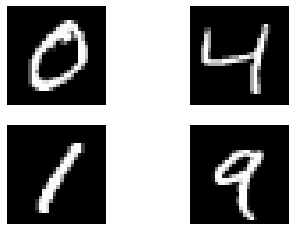

In [11]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Let's now set up a few general setting before using torch

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

```
# 이전에는 이런 형식이었던 것 같은데
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

```

* and define our first conv-net!<br>
* We'll use 3 layers of convolutions and two fully connected layers

In [26]:
# Define new Models
# "You can define your own Modules using autograd!"

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [27]:
"""
# e.g. Conv2d
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)  # input_channel, output_channel, kernel_size, stride
# non-square kernels and unequal stride and with padding
# m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
# non-square kernels and unequal stride and with padding and dilation
# m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = torch.randn(20, 16, 50, 100)  # num_input, channel, width, height
output = m(input)
print("output.shape: ", output.shape)  # (20, 33, 24, 49)



# e.g. dropout
m = nn.Dropout(p=0.5)
input = torch.randn(20, 16)
x = m(input)
print("x.shape: ", x.shape)


# maxpool2d
# pool of square window of size=3, stride=2
m = nn.MaxPool2d(3, stride=2)
# pool of non-square window
input = torch.randn(20, 16, 50, 32)
output = m(input)
print("maxpool2d: ", output.shape)

"""

'\n# e.g. Conv2d\n# With square kernels and equal stride\nm = nn.Conv2d(16, 33, 3, stride=2)  # input_channel, output_channel, kernel_size, stride\n# non-square kernels and unequal stride and with padding\n# m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))\n# non-square kernels and unequal stride and with padding and dilation\n# m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))\ninput = torch.randn(20, 16, 50, 100)  # num_input, channel, width, height\noutput = m(input)\nprint("output.shape: ", output.shape)  # (20, 33, 24, 49)\n\n\n\n# e.g. dropout\nm = nn.Dropout(p=0.5)\ninput = torch.randn(20, 16)\nx = m(input)\nprint("x.shape: ", x.shape)\n\n\n# maxpool2d\n# pool of square window of size=3, stride=2\nm = nn.MaxPool2d(3, stride=2)\n# pool of non-square window\ninput = torch.randn(20, 16, 50, 32)\noutput = m(input)\nprint("maxpool2d: ", output.shape)\n\n'

Next>> we can write the train and test functions

In [28]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

Then we are ready to instantiate our model and start the training!


In [29]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [30]:
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.797820
Test set: Average loss: 0.0012, Accuracy: 9096/10000 (91%)

Train Epoch: 2 	Loss: 0.868252
Test set: Average loss: 0.0007, Accuracy: 9459/10000 (95%)



Wow! 96% accuracy in such a short time!<br>

**Questions to explore:**

* Can you find a better parametrization to improve the final accuracy?
* Can you change the network architecture to improve the final accuracy?
* Can you achive the same performances with a smaller architecture?
* What's the difference in accuracy if you change convolutions with fully connected layers?

Some tips here: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354




> But what if now we want the same model being able to solve a new task we encounter over time like a permuted version of the same MNIST? Let's define our custom function to permute it!



* we want to same model being able to solve a new task that we encounter overtime
* like a permuted version of the same MNIST
* Let's define our custom function to permute it!

In [31]:
def permute_mnist(mnist, seed):
    """
    Given the training set, permute pixels of each img the same way
    """
    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))  # <- 순열 인덱스, mnist 이미지를 flatten시킨 각각의 데이터가 하나의 인덱스가 된다
    np.random.shuffle(perm_inds)  # 슦아
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)  # flatten 시킨 set
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))  # 같은 shape이지만 완전히 random한 값이 만들어진다
    print("done.")
    return perm_mnist

In [32]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 0)

print(x_train2.shape, x_test2.shape)

starting permutation...
done.
(60000, 1, 28, 28) (10000, 1, 28, 28)


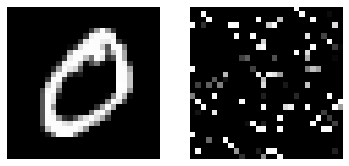

In [33]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[1, 0], cmap="gray")
axarr[1].imshow(x_train2[3, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Amazing. Now let's see how our pre-trained model is working on both the original and the permuted MNIST dataset:



In [34]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0007, Accuracy: 9459/10000 (95%)

Testing on the second task:
Test set: Average loss: 0.0105, Accuracy: 829/10000 (8%)



Mmmh... that's pretty bad. our model cannot generalize to this apparently very different new task!<br>
Well, we can just finetune our model using the new permuted training set!

* 데이터가 완전 바뀌니깐 기존의 모델이 제대로된 성능을 보여주지 못햇다
    * task1으로 학습한 모델로 task2를 평가하면 96%에서 11%로 성능이 매우 안좋아졌다

* 생각
    * 이렇게 결과가 나오는게 이상하지 않다고 생각한다
        * 어쩌면 당연한게... 모델이 마주친 데이터가 기존의 데이터와 너무 다르다...! -21.01.06.wed- 

In [ ]:
for epoch in range(1, 3):
    train(model, device, x_train2, t_train, optimizer, epoch)
    test(model, device, x_test2, t_test)

Train Epoch: 1 	Loss: 1.040976
Test set: Average loss: 0.0027, Accuracy: 7808/10000 (78%)

Train Epoch: 2 	Loss: 0.987049
Test set: Average loss: 0.0020, Accuracy: 8425/10000 (84%)



In [ ]:
print("Testing on the first task: ")
test(model, device, x_test, t_test)

print("Testing on the second task: ")
test(model, device, x_test2, t_test)

Testing on the first task: 
Test set: Average loss: 0.0291, Accuracy: 2087/10000 (21%)

Testing on the second task: 
Test set: Average loss: 0.0020, Accuracy: 8425/10000 (84%)



84.25

This is very annoying! Now we are not able to solve the original MNSIT task anymore! :-( This is the phenomenon known in literature as Catastrophic Forgetting! In the following section we well compare three different strategies for learning continually (and trying to not forget!)

상당히 흥미롭다...!<br>

> 이녀석...! 새로운 문제를 푸니깐 기존의 문제를 전혀 풀지 못하잖어?!

* task1로 학습한 모델이 task2를 제대로 학습하지 못해서 task2를 잘 학습한 모델을 구축함
* task2를 잘 학습하게 되니깐 task1에 대해서는 성능이 매우 안좋은 모델로 바뀜...(a.k.a catastrophic forgetting)

**Questions to explore**
* When the permuted MNIST benchmark has been firstly introduced?
* Can simple Dropout and Regularization techniques reduce forgetting?
* In the permuted MNIST task, do convolutions still help increasing the accuracy?

https://papers.nips.cc/paper/2013/hash/8f1d43620bc6bb580df6e80b0dc05c48-Abstract.html

## CL Strategies

**Questions**<br>
What is CL Strategies?
-> `Continual Learning` Strategiy!<br>
1. Naive
2. Rehearsal
3. Elastic Weight Consolidation (EWC)
<br>

In this section, we'll take a look at three different strategies and run it on a 3-tasks Permuted MNIST<br>

Finally we'll plot our results for comparison.<br>

For a more comprehensive overview on recent CL strategies for deep learning, take a look at the recent paper<br>

<a href="https://arxiv.org/abs/1806.08568">Continuous Learning in Single-Incremental-Task Scenarios</a>


Let's start by defining our 3 tasks with the function we have already introduced before

In [ ]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

starting permutation...
done.
starting permutation...
done.


task2와 task3이 각각 variant malware라면 어떨까?<br>
* 이렇게 될 경우 변종 악성코드라는 새로운 task를 학습했을 때 기존 task에 대한 성능을 평가함으로써 기존 방법의 문제점을 검증할 수 있지 않을까?

## Idea
* 각각의 task를 VAE를 사용해서 만들어준다면 어떨까?
* 랜덤하게 값을 만들어주는 것뿐만아니라 입력 데이터의 분포를 띄게 조건도 걸어줄 수 있으니 효과적이지 않을까?
* 이렇게 Multi-task에 대해서도 학습이 잘 된다면 보다 완강한 분류기가 되지 않을까...!

<br>
After Search<br>

* 이미 'Variational Continual Learning'라는 논문이 발표되었다
    * 역시는 역시...!
    * 사람들이 생각하는 것들은 비슷비슷하다...!
    * ✅ (적어도) Variational Continual Learning의 핵심 개념과 방법에 대해서는 알고 넘어갈 필요가 있다고 생각한다

### Naive Strategy
* The Naive Stragegy, is the simple idea of continuing the back-prop process on the new batches/tasks
* This is very simple, but at the same time very prone to forgetting as we have witnessed before
* Let's how it works on three tasks

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
naive_accs = []

for id, task in enumerate(tasks):
    avg_acc = 0
    print("Training on task: ", id)

    (x_train, t_train), _ = task

    for epoch in range(1, 2):
        train(model, device, x_train, t_train, optimizer, epoch)

    for id_test, task in enumerate(tasks):
        print("Testing on task: ", id_test)
        _, (x_test, t_test) = task
        acc = test(model, device, x_test, t_test)
        avg_acc = avg_acc + acc

    naive_accs.append(avg_acc / 3)
    print("Avg acc: ", avg_acc/3)

Training on task:  0
Train Epoch: 1 	Loss: 0.669325
Testing on task:  0
Test set: Average loss: 0.0011, Accuracy: 9167/10000 (92%)

Testing on task:  1
Test set: Average loss: 0.0114, Accuracy: 703/10000 (7%)

Testing on task:  2
Test set: Average loss: 0.0101, Accuracy: 1415/10000 (14%)

Avg acc:  37.61666666666667
Training on task:  1
Train Epoch: 1 	Loss: 1.827566
Testing on task:  0
Test set: Average loss: 0.0231, Accuracy: 1459/10000 (15%)

Testing on task:  1
Test set: Average loss: 0.0053, Accuracy: 5877/10000 (59%)

Testing on task:  2
Test set: Average loss: 0.0105, Accuracy: 1366/10000 (14%)

Avg acc:  29.006666666666664
Training on task:  2
Train Epoch: 1 	Loss: 1.177152
Testing on task:  0
Test set: Average loss: 0.0278, Accuracy: 2094/10000 (21%)

Testing on task:  1
Test set: Average loss: 0.0086, Accuracy: 2705/10000 (27%)

Testing on task:  2
Test set: Average loss: 0.0032, Accuracy: 7595/10000 (76%)

Avg acc:  41.31333333333333


**Questions to explore**<br>
* Does the order of the tasks effect the final results?

### Rehearsal Strategy
* another simple CL idea is to carry on all or part of the previously encountered examples shuffling them with the data of the current task
* Using all the past data is near to the optimal performance we can desire at the end of the task sequence
* but at the expense of much bigger memory usage

In [ ]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []

    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

Now we can reset the model and optimizer and run our training over the tasks sequence

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
rehe_accs = []

for id, task in enumerate(tasks):
    avg_acc = 0
    print("Traininig on task: ", id)

    (x_train, t_train), _ = task

    # for previous task
    for i in range(id):
        (past_x_train, past_t_train), _ = tasks[i]
        x_train = np.concatenate((x_train, past_x_train))
        t_train = np.concatenate((t_train, past_t_train))
    
    x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

    for epoch in range(1, 2):
        train(model, device, x_train, t_train, optimizer, epoch)

    for id_test, task in enumerate(tasks):
        print("Testing on task: ", id_test)
        _, (x_test, t_test) = task
        acc = test(model, device, x_test, t_test)
        avg_acc = avg_acc + acc

    print("Avg acc: ", avg_acc /3)
    rehe_accs.append(avg_acc/3)

Traininig on task:  0
Train Epoch: 1 	Loss: 0.175732
Testing on task:  0
Test set: Average loss: 0.0005, Accuracy: 9592/10000 (96%)

Testing on task:  1
Test set: Average loss: 0.0117, Accuracy: 775/10000 (8%)

Testing on task:  2
Test set: Average loss: 0.0099, Accuracy: 1181/10000 (12%)

Avg acc:  38.49333333333333
Traininig on task:  1
Train Epoch: 1 	Loss: 0.507613
Testing on task:  0
Test set: Average loss: 0.0005, Accuracy: 9631/10000 (96%)

Testing on task:  1
Test set: Average loss: 0.0025, Accuracy: 8138/10000 (81%)

Testing on task:  2
Test set: Average loss: 0.0116, Accuracy: 955/10000 (10%)

Avg acc:  62.413333333333334
Traininig on task:  2
Train Epoch: 1 	Loss: 0.382790
Testing on task:  0
Test set: Average loss: 0.0004, Accuracy: 9660/10000 (97%)

Testing on task:  1
Test set: Average loss: 0.0018, Accuracy: 8655/10000 (87%)

Testing on task:  2
Test set: Average loss: 0.0021, Accuracy: 8430/10000 (84%)

Avg acc:  89.14999999999999


**Questions to explore:**<br>

* Can you find a way to reduce the number of examples of the previous tasks to maintain in memory?
* Can you find a good trade-off between memory overhead and final accuracy?
* Why is shuffling needed here?

### Elastic Weights Consolidation (EWC) Strategy
* Elastic Weights Consolidation is a common CL strategy firstly proposed in the paper "Overcoming catastrophic forgetting in neural networks" for deep neural networks

* It is based on the computation of the importance of each weight (fisher information) and a squared regularization loss, penalizing changes in the most important weights for the previous tasks

> It has the great advantage of not using any of the previous tasks data!

In [ ]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()
  
  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():
    
    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

In [ ]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      
      ### magic here! :-)
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda
      
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [ ]:
ewc_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task
  
  for epoch in range(1, 3):
    train_ewc(model, device, id, x_train, t_train, optimizer, epoch)
  on_task_update(id, x_train, t_train)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / 3)
  ewc_accs.append(avg_acc / 3)

Training on task:  0
Train Epoch: 1 	Loss: 0.588102
Train Epoch: 2 	Loss: 0.346697
Testing on task:  0
Test set: Average loss: 0.0005, Accuracy: 9573/10000 (96%)

Testing on task:  1
Test set: Average loss: 0.0133, Accuracy: 885/10000 (9%)

Testing on task:  2
Test set: Average loss: 0.0106, Accuracy: 1451/10000 (15%)

Avg acc:  39.696666666666665
Training on task:  1
Train Epoch: 1 	Loss: 1.695190
Train Epoch: 2 	Loss: 1.492106
Testing on task:  0
Test set: Average loss: 0.0106, Accuracy: 4624/10000 (46%)

Testing on task:  1
Test set: Average loss: 0.0033, Accuracy: 7712/10000 (77%)

Testing on task:  2
Test set: Average loss: 0.0109, Accuracy: 1132/10000 (11%)

Avg acc:  44.89333333333334
Training on task:  2
Train Epoch: 1 	Loss: 1.720555
Train Epoch: 2 	Loss: 1.597846
Testing on task:  0
Test set: Average loss: 0.0084, Accuracy: 6430/10000 (64%)

Testing on task:  1
Test set: Average loss: 0.0079, Accuracy: 3475/10000 (35%)

Testing on task:  2
Test set: Average loss: 0.0035, Accu

### Plot Results
To conclude, let's summerize our results in a nice plot!

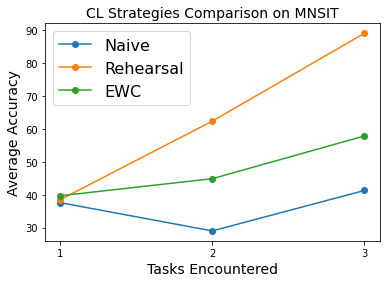

In [ ]:
plt.plot([1, 2, 3], naive_accs, '-o', label="Naive")
plt.plot([1, 2, 3], rehe_accs, '-o', label="Rehearsal")
plt.plot([1, 2, 3], ewc_accs, '-o', label="EWC")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies Comparison on MNSIT', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});


Copyright (c) 2018. Continual AI. All rights reserved.

See the accompanying LICENSE file in the GitHub repository for terms.

Date: 29-09-2018
Author: Vincenzo Lomonaco
E-mail: contact@continualai.org
Website: continualai.org